In [1]:
import sys
import theano
import os
import time
import numpy as np
import theano.tensor as T
from theano import function
from theano.tensor.shared_randomstreams import RandomStreams
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DropoutLayer, \
Deconv2DLayer, DenseLayer, Upscale2DLayer, ReshapeLayer, \
get_output, get_all_params, get_all_layers,  count_params
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import linear
from lasagne.objectives import squared_error
from lasagne.updates import nesterov_momentum
import matplotlib
import matplotlib.pyplot as plt
import h5py
import copy
import time
if __name__ == "__main__":
    sys.path.insert(0,'..')
    from common import data_iterator, create_run_dir
else:
    from ..common import data_iterator, create_run_dir

%matplotlib inline

import time
#import util.preprocessing
from sklearn.manifold import TSNE

#enable importing of notebooks
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())



import numpy as np

In [2]:


def build_network(nkwargs):
    
    opt_kwargs = {k:nkwargs[k] for k in ['learning_rate','momentum']}

    input_var = T.tensor4('input_var')
    target_var = T.tensor4('target_var')

    network, hid_layer = build_denoising_convae(input_var, nkwargs)
    
    #get outputs
    prediction = get_output(network, deterministic=False)
    hid_layer_output = get_output(hid_layer, deterministic=True)
    
    #make losses
    loss = squared_error(prediction, target_var).mean()
    test_prediction = get_output(network, deterministic=True)
    test_loss = squared_error(test_prediction,target_var).mean()
    test_acc = test_loss 
    
    #set up updates
    params = get_all_params(network, trainable=True)
    updates = nesterov_momentum(loss, params, **opt_kwargs)

    
    #make fns
    train_fn = function([input_var, target_var], loss, updates=updates)
    val_fn = function([input_var, target_var], [test_loss, test_acc])
    pred_fn = function([input_var], test_prediction)
    hlayer_fn = function([input_var], hid_layer_output )

    return train_fn, val_fn, pred_fn, hlayer_fn, network

def build_denoising_convae(input_var, nkwargs):
    
    corrupted_input = corrupt(input_var, nkwargs)
    
    hid_layer = build_encoder(corrupted_input, nkwargs)
    

    network = build_decoder(hid_layer, nkwargs)

    print_layers(network)
    
    return network, hid_layer

def build_encoder(input_var, nkwargs):
    
    conv_kwargs = {k: nkwargs[k] for k in ['num_filters', 'W', 'nonlinearity']}
    dense_kwargs = {k: nkwargs[k] for k in ['num_units','W', 'nonlinearity']}
    
    net = InputLayer(shape=nkwargs['input_shape'], input_var=input_var)
    net = Conv2DLayer(net, filter_size=(2,2),stride=2, **conv_kwargs)
    net = Conv2DLayer(net, filter_size=(2,2),stride=2, **conv_kwargs)
    net = Conv2DLayer(net, filter_size=(2,2),stride=2, **conv_kwargs)
    net = DropoutLayer(net, p=nkwargs['p'])
    net = DenseLayer(net, **dense_kwargs)
    
    return net

def build_decoder(hid_layer, nkwargs):
    
    # the last shape before the fully connected layers
    last_conv_shape = get_last_conv_shape(hid_layer)
    
    #set kwargs
    dc_kwargs = {k: nkwargs[k] for k in ['num_filters', 'W', 'nonlinearity']}
    edc_kwargs = dict(num_filters=nkwargs['input_shape'][1],W=nkwargs['W'], nonlinearity=linear)
    fc_kwargs = {k: nkwargs[k] for k in ['W', 'nonlinearity']}
    fc_kwargs.update({'num_units': np.prod(last_conv_shape[1:]) })

    #make layers
    net = DropoutLayer(hid_layer, p=nkwargs['p'])
    net = DenseLayer(net, **fc_kwargs)
    d1, d2, d3 = last_conv_shape[1:]
    net = ReshapeLayer(net, shape= ([0], d1,d2,d3))
    net = Deconv2DLayer(net, filter_size=(2,2), stride=(2,2), **dc_kwargs)
    net = Deconv2DLayer(net, filter_size=(2,2), stride=(2,2), **dc_kwargs)
    net = Deconv2DLayer(net, filter_size=(2,2), stride=(2,2), **edc_kwargs)
    
    return net

    

def corrupt(input_var, nkwargs):
    rng = np.random.RandomState(498)
    theano_rng = RandomStreams(rng.randint(2 ** 30))
    
    if 'corruption' not in nkwargs:
        corrupted_input = input_var
    elif nkwargs['corruption'] == 'binomial':
        corruped_input = theano_rng.binomial(size=input_var.shape, n=1,p=1 - corruption_p) * input_var
    elif nkwargs['corruption'] in ['gaussian', 'normal']:
        corrupted_input = theano_rng.normal(size=input_var.shape, avg=0.0, std=1.0) * input_var
    else:
        corrupted_input = input_var
                    
    return corrupted_input

def get_last_conv_shape(network):
    lay = copy.deepcopy(network)
    while type(lay) != lasagne.layers.conv.Conv2DLayer:
        lay = lay.input_layer
    last_conv_shape = lay.output_shape
    return last_conv_shape

def print_layers(network):
    for layer in get_all_layers(network):
        print str(type(layer)).split(".")[-1][:-2] +': ' + str(layer.output_shape)
    print count_params(layer)

InputLayer: (None, 16, 128, 128)
Conv2DLayer: (None, 32, 64, 64)
Conv2DLayer: (None, 32, 32, 32)
Conv2DLayer: (None, 32, 16, 16)
DropoutLayer: (None, 32, 16, 16)
DenseLayer: (None, 2)
DropoutLayer: (None, 2)
DenseLayer: (None, 8192)
ReshapeLayer: (None, 32, 16, 16)
TransposedConv2DLayer: (None, 32, 32, 32)
TransposedConv2DLayer: (None, 32, 64, 64)
TransposedConv2DLayer: (None, 16, 128, 128)
61618
day 0
0.333638449099
0.332672730209
0.331769744393
0.330668371128
0.328205239758
0.325324569499
0.321377805052
0.317319719523
 epoch 0 loss is 0.33


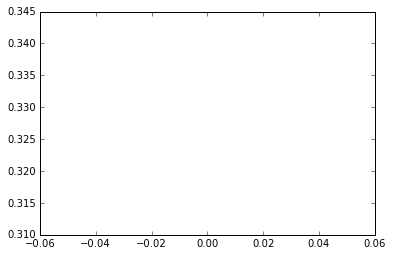

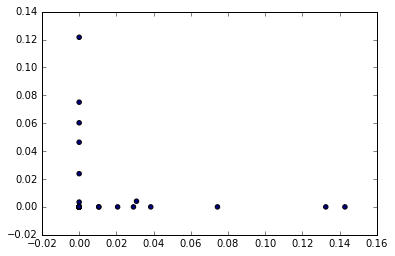

day 0
0.31371541443
0.310214650104
0.307042278233
0.304037542309
0.299965672703
0.295682009123
0.290669013125
0.285758123684
 epoch 1 loss is 0.30


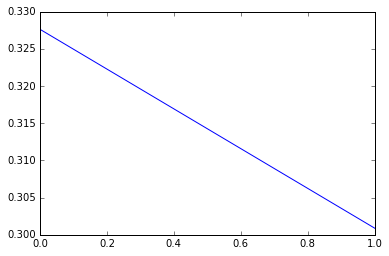

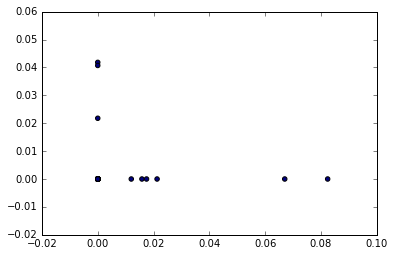

day 0
0.281465733087
0.277371393734
0.273844388727
0.270541551981
0.266359698643
0.262071941039
0.257239284314
0.252525203488
 epoch 2 loss is 0.27


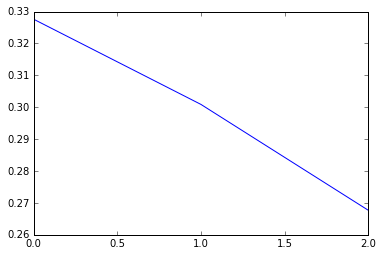

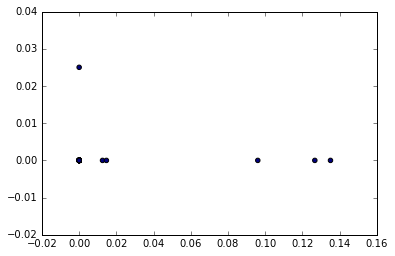

day 0
0.24853827328
0.244736785233
0.241511915327
0.238584347007
0.234846292571
0.231076267377
0.226798829916
0.222694716859
 epoch 3 loss is 0.24


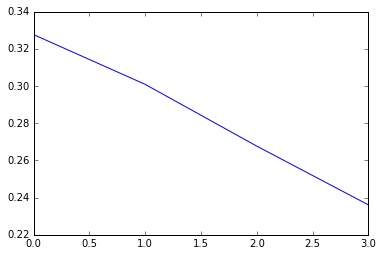

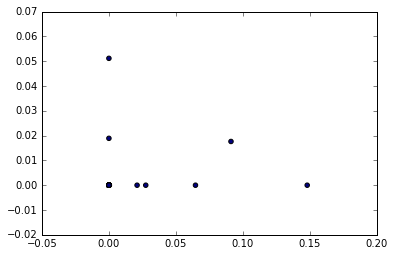

day 0
0.219290679597
0.216037804109
0.213383390559
0.211012931614
0.207887601624
0.204726281681
0.201113498549
0.197647550222
 epoch 4 loss is 0.21


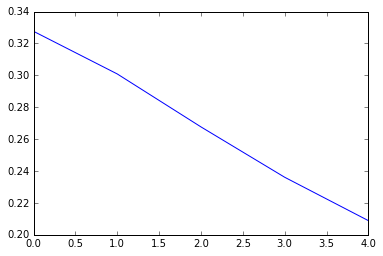

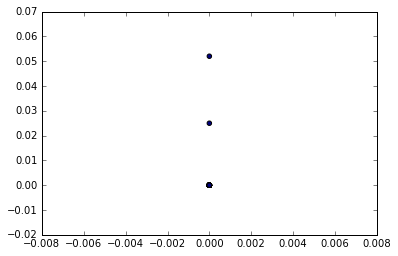

day 0
0.194880057068
0.192220667043
0.190121112666
0.188288141628
0.185756152064
0.183164701823
0.180145908585
0.177307263967
 epoch 5 loss is 0.19


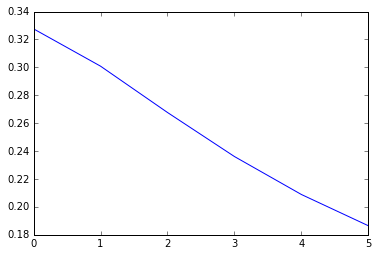

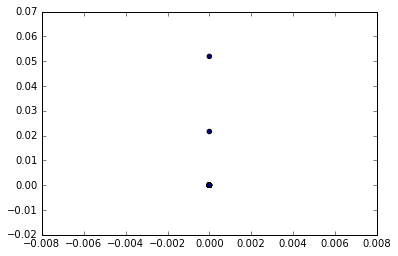

day 0
0.175104345936
0.172938283388
0.171340990636
0.169998153742


KeyboardInterrupt: 

In [3]:
if __name__ == "__main__":
    run_dir = create_run_dir()
    dnkwargs = dict(         learning_rate = 0.01,
                              input_shape=(None,16,128,128),
                              momentum = 0.9,
                              num_filters=32,
                              num_units=2,
                              nonlinearity=relu,
                              W=lasagne.init.HeNormal(),
                              p=0.,
                              corruption_p = 0.3,
                              load=False, 
                              load_path=None, corruption='gaussian')
    
    train_fn, val_fn, pred_fn, hlayer_fn, network = build_network(dnkwargs)
    
    
    num_epochs = 5000
    losses = []

    for epoch in range(num_epochs):
        start = time.time() 
        tr_loss = 0
        for iteration, (x, y) in enumerate(data_iterator(54, step_size=128, days=1)):

            x = np.squeeze(x)
            loss = train_fn(x,x)
            #print loss
            tr_loss += loss
        epoch_loss = tr_loss / (iteration + 1)
        print "time : %5.2f seconds" % (time.time() - start)
        print " epoch %i of %i loss is %.2f" % (epoch,num_epochs, epoch_loss)
        losses.append(epoch_loss)
        plt.plot(losses)
        plt.show()
        plt.savefig(run_dir + '/learn_curve.png')
        plt.clf()
        hid_L = hlayer_fn(x)
        ts = hid_L#TSNE().fit_transform(hid_L)
        print np.max(y)
        plt.scatter(ts[:,0], ts[:,1], c=y)
        plt.show()
        plt.savefig(run_dir + '/cluster.png')
        plt.clf()

    
        
    

In [6]:
import time
a = time.time()

In [7]:
b =time.time()

In [8]:
b -a 

0.7299470901489258